This Notebook provides an example of how to run the TextToImageSemanticSearcher class to get and display the images matching 
a particular query. The images are displayed using 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sys.path.append("/home/akash/Documents/cs511/semantic-sql")

In [4]:
from text_to_image_semantic_search import TextToImageSemanticSearcher, create_and_save_faiss_index_with_ids, save_ids_and_index

/home/akash/Documents/cs511/semantic-sql/semantic-sql-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### first, you will need to download embedding_instances.pt and the imageids-instances.pt from our google drive folder
### this basically is a map of all the imageids and the corresponding embeddings for the 20000 images in the csv


In [10]:
d = pd.read_csv("../data/objects.csv")

In [148]:
create_and_save_faiss_index_with_ids(embeddings_path='../data/embeddings-instances.pt', ids_path='../data/imageIds-instances.pt')

In [5]:
searcher = TextToImageSemanticSearcher(index_path='../data/index', ids_path="../data/index_ids.npy")

In [6]:
# percentile must be between 0 and 1 with 1 being the highest similarity
query = "women with umbrella and two cars"

In [11]:
images = searcher.get_images_from_ids(searcher.generate_all_image_scores(query)[0][:3])

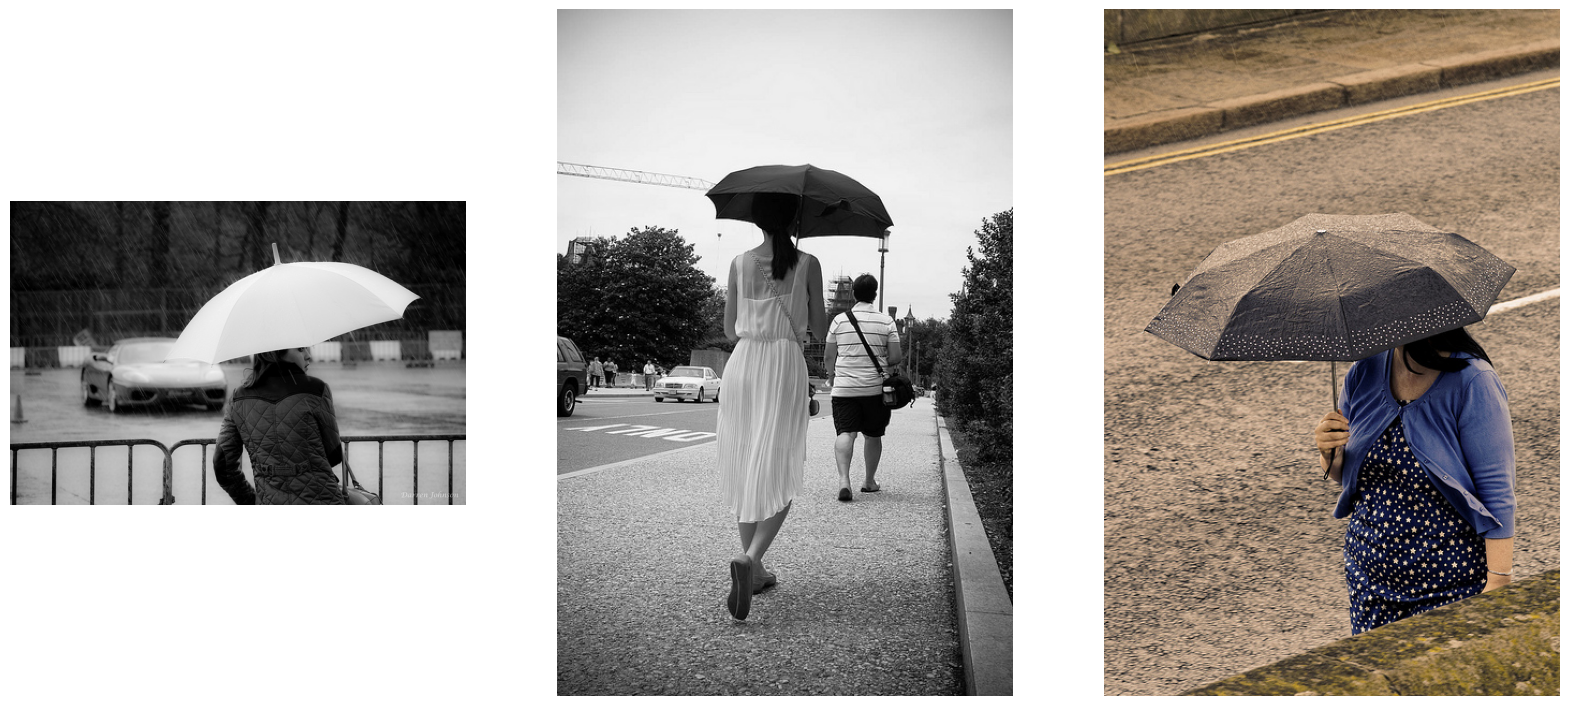

In [12]:
plt = searcher.plot_images(images)

# Count experiment 

In [80]:
a = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]
d = pd.read_csv("../data/objects.csv")
f = d[d["class_name"]=="car"]["id"].value_counts()

In [81]:
searcher.generate_all_image_scores(query)[0][:3]

[283968, 260580, 321089]

In [82]:
for c1, c2 in zip(list(range(1,11)), a):
    q = f"{c2} car"
    if c1 > 1:
        q += "s"
    images = set(searcher.generate_all_image_scores(q)[0][:3])
    print(set(f[f==c1].index).intersection(images))

{158130, 253094}
set()
{255975}
set()
set()
set()
set()
set()
set()
set()


In [94]:
f[f==10].index

Index([475208, 420465, 362343,   5237, 460652, 568432, 567118, 565286, 119802,
       558602, 240764, 235919, 117071, 515765,  50161, 565018,  54485,  15379,
       230615, 384857, 375304, 543166, 290849, 171678, 392949, 534426,  44671,
       528951, 184667, 495626, 528351, 146656, 101687, 373060, 372620, 367710],
      dtype='int64', name='id')

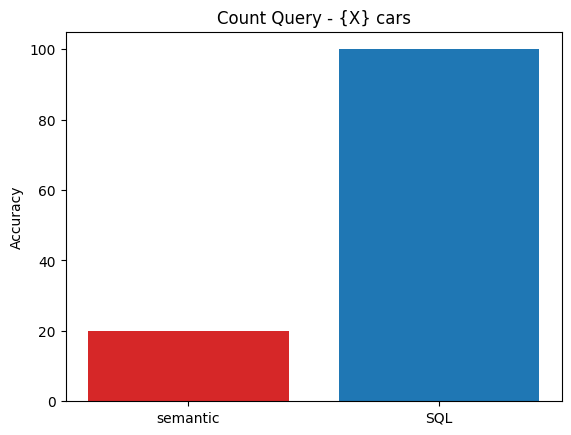

In [83]:
fig, ax = plt.subplots()

type_query = ['semantic', 'SQL']
counts = [20, 100]
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(type_query, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_title('''Count Query - {X} cars''')

plt.show()


# Spatial Locality Queries

In [57]:
n = d[~d["id"].isin(d[(d["class_name"]=="person") | (d["class_name"]=="car")]["id"].unique())]

In [97]:
top_left = n[(n['x1'] > 320) & (n['y1'] > 320)]

In [98]:
count = 0
total_objs = 0
for obj in top_left["class_name"].unique():
    total_objs += 1
    q = f"{obj} in the bottom right corner"
    images = set(searcher.generate_all_image_scores(q)[0][:3])
    answer = set(top_left[top_left["class_name"]==obj]["id"].unique()).intersection(images)
    if len(answer) > 0:
        count += 1

In [99]:
accuracy = count/total_objs

In [100]:
print(accuracy)

0.1044776119402985


In [101]:
print("Total Objects - ", total_objs)

Total Objects -  67


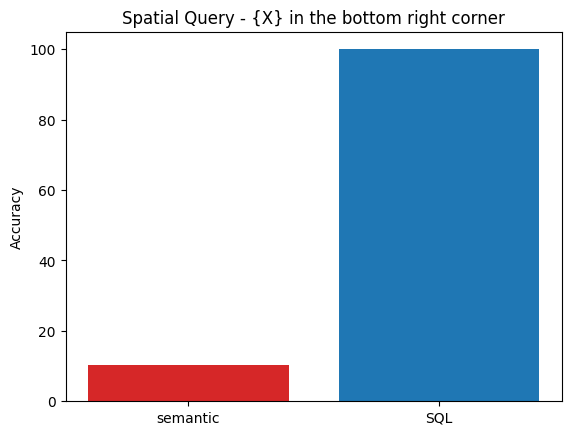

In [104]:
fig, ax = plt.subplots()

type_query = ['semantic', 'SQL']
counts = [accuracy*100.0, 100]
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(type_query, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_title('''Spatial Query - {X} in the bottom right corner''')

plt.show()

# Multiple objects at the same time 

In [117]:
all_objs = list(d["class_name"].unique())
images_with_objs = {}

In [118]:
for obj in all_objs:
    images_with_objs[obj] = set(d[d["class_name"]==obj]["id"].unique())

In [119]:
total_valid = 0
count_ans = 0

In [ ]:
for i in range(len(all_objs)):
    print(i)
    for j in range(i+1, len(all_objs)):
        obj1 = all_objs[i]
        obj2 = all_objs[j]
        q = f"{obj1} and {obj2}"
        sql_ans = images_with_objs[obj1].intersection(images_with_objs[obj2])
        if len(sql_ans) < 1:
            continue
        total_valid += 1
        images = set(searcher.generate_all_image_scores(q)[0][:3])
        answer = set(sql_ans).intersection(images)
        if len(answer) > 0:
            count_ans += 1

In [122]:
accuracy = count_ans/total_valid

In [123]:
print(accuracy)

0.32015065913371


In [124]:
count_ans

680

In [125]:
total_valid

2124

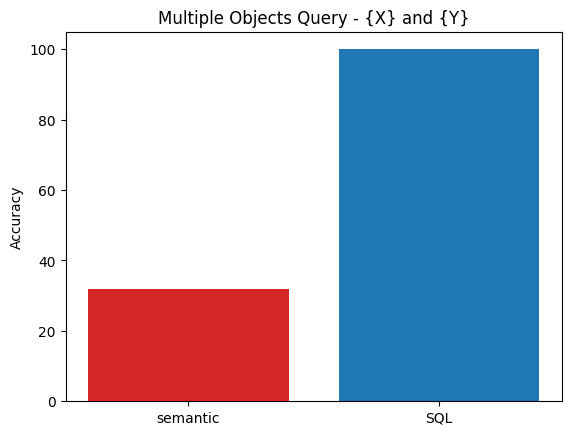

In [127]:
fig, ax = plt.subplots()

type_query = ['semantic', 'SQL']
counts = [accuracy*100.0, 100]
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(type_query, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Accuracy')
ax.set_title('''Multiple Objects Query - {X} and {Y}''')

plt.show()